## Naive Bayes
This notebook runs the drug repurposing project's second model, Naive Bayesian. Run all 50 assays, will create balanced and unbalanced models using the sample weight in sklearn.

### Unbalanced

### Read in data

In [3]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

from sklearn import preprocessing
from sklearn.utils import compute_class_weight
from sklearn.naive_bayes import BernoulliNB

import pymc as pm
import aesara.tensor as T
import arviz as az


In [2]:
xls = pd.ExcelFile('assay_list.xls')

# Now you can list all sheets in the file
xls.sheet_names

# to read just one sheet to dataframe:
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

len(df)


34

In [3]:
xls2 = pd.ExcelFile('assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)



50

In [4]:
df[49]

,Unnamed: 0,tox21-rt-viability-hek293-p1,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,1,[Br-].CCCCCCCCCCCCCC[n+]1ccccc1,2.287998,0.000000,2.287998,0.000000,0.377974,356.392,322.120,...,0,0,0,0,0,0,0,0,10,0
1,1,0,C[C@]12CC[C@H](C[C@H]1O)C2(C)C,9.814236,-0.031250,9.814236,0.031250,0.566800,154.253,136.109,...,0,0,0,0,0,0,0,0,0,0
2,2,1,CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC,2.473380,0.534907,2.473380,0.534907,0.689255,255.405,230.205,...,0,0,0,0,0,0,0,0,0,0
3,3,0,OCC(=O)OCCCC,10.214402,-0.538472,10.214402,0.426481,0.442392,132.159,120.063,...,0,0,0,0,0,0,0,0,1,0
4,4,0,O=C(O)[C@@H](C)Oc4ccc(CNC(=O)c3cccnc3Oc1ccc2OC...,14.392580,-1.164824,14.392580,0.070133,0.531189,454.410,435.258,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8649,8783,0,BrCCCCCCCCCC,3.443408,1.182500,3.443408,1.182500,0.417177,221.182,200.014,...,0,0,0,0,0,0,0,0,6,0
8650,8784,0,CC/C(=N\OC\C=C\Cl)C1=C(O)CC(CC(C)SCC)CC1=O,12.447525,-0.037469,12.447525,0.037469,0.363123,359.919,333.711,...,1,0,0,0,0,0,0,0,1,0
8651,8785,1,CCN(CC)c1ccc(cc1)/N=N/c2ccccc2,4.235067,0.870666,4.235067,0.870666,0.692852,253.349,234.197,...,0,0,0,0,0,0,0,0,0,0
8652,8786,0,O=C(c1ccc(Cl)cc1)c2ccccc2,11.914512,0.020617,11.914512,0.020617,0.701803,216.667,207.595,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(df[49].iloc[:,1].value_counts())
print(pd.factorize(df[49].iloc[:,1]))
t = pd.factorize(df[49].iloc[:,1])
print(np.unique(t[0], return_counts=True))

0    7198
1    1456
Name: tox21-rt-viability-hek293-p1, dtype: int64
(array([0, 1, 0, ..., 0, 1, 1]), Int64Index([1, 0], dtype='int64'))
(array([0, 1]), array([1456, 7198]))


The pd.factorize() is swapping the 0s and 1s, so need to proceed with label encoding.

In [6]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
t = label_encoder.fit_transform(df[49].iloc[:,1])
  
np.unique(t, return_counts=True)

(array([0, 1]), array([7198, 1456]))

In [7]:
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
label_encoder = preprocessing.LabelEncoder()
one_assay = df[0]
scaler = StandardScaler().fit(one_assay.iloc[:,3:])
X = scaler.transform(one_assay.iloc[:,3:])
y = label_encoder.fit_transform(one_assay.iloc[:,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

In [8]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([7164,  583]))
(array([0, 1]), array([1788,  149]))


#### Single Assay

In [9]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(alpha = 50).fit(X_train, y_train)


In [22]:
y_pred_unbalanced = clf.predict(X_test)
y_pred_decision = clf.predict_proba(X_test)
y_pred_decision

array([[1.09712759e-09, 9.99999999e-01],
       [1.00000000e+00, 1.83324173e-14],
       [8.50051731e-09, 9.99999991e-01],
       ...,
       [1.00000000e+00, 3.77307446e-19],
       [2.95712455e-04, 9.99704288e-01],
       [9.55697484e-01, 4.43025163e-02]])

In [23]:
print("Unbalanced model report")
print(classification_report(y_test,y_pred_unbalanced))

Unbalanced model report
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1788
           1       0.15      0.60      0.24       149

    accuracy                           0.71      1937
   macro avg       0.55      0.66      0.53      1937
weighted avg       0.89      0.71      0.77      1937



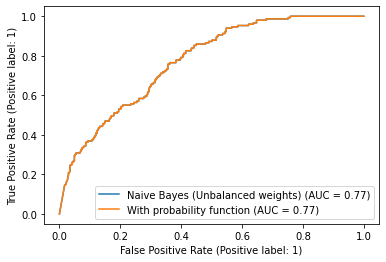

0.7735762653333933


In [30]:
ax = plt.gca()

RocCurveDisplay.from_estimator(clf, X_test, y_test,ax=ax,name="Naive Bayes (Unbalanced weights)")
RocCurveDisplay.from_predictions(y_test,y_pred_decision[:,1], ax=ax,name="With probability function")

plt.show()

print(metrics.roc_auc_score(y_test, y_pred_decision[:, 1]))

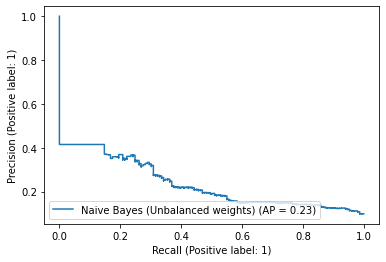

In [25]:
ax = plt.gca()

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test,ax=ax,name="Naive Bayes (Unbalanced weights)")
# PrecisionRecallDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

### Run all 50 assays

tox21-ahr-p1
              precision    recall  f1-score   support

           0       0.96      0.71      0.81      1795
           1       0.15      0.65      0.24       142

    accuracy                           0.70      1937
   macro avg       0.56      0.68      0.53      1937
weighted avg       0.90      0.70      0.77      1937



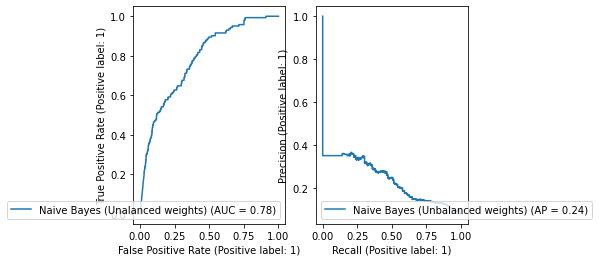

tox21-ap1-agonist-p1
              precision    recall  f1-score   support

           0       0.97      0.73      0.84      1728
           1       0.09      0.57      0.16        84

    accuracy                           0.72      1812
   macro avg       0.53      0.65      0.50      1812
weighted avg       0.93      0.72      0.80      1812



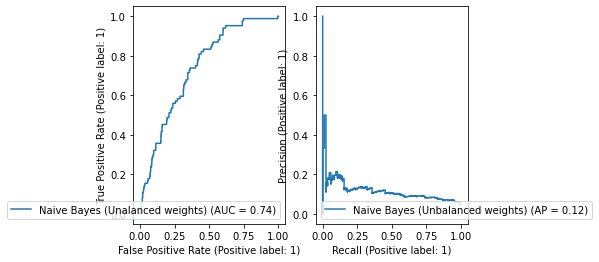

tox21-ar-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.94      0.69      0.79      1704
           1       0.18      0.62      0.28       192

    accuracy                           0.68      1896
   macro avg       0.56      0.65      0.54      1896
weighted avg       0.86      0.68      0.74      1896



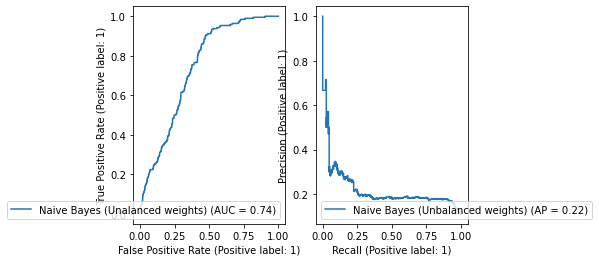

tox21-ar-mda-kb2-luc-agonist-p3
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      1602
           1       0.21      0.63      0.32       199

    accuracy                           0.70      1801
   macro avg       0.58      0.67      0.56      1801
weighted avg       0.86      0.70      0.75      1801



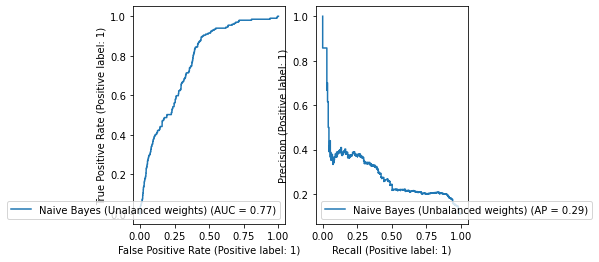

tox21-ar-mda-kb2-luc-antagonist-p1
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1825
           1       0.15      0.62      0.24       156

    accuracy                           0.69      1981
   macro avg       0.55      0.66      0.52      1981
weighted avg       0.89      0.69      0.76      1981



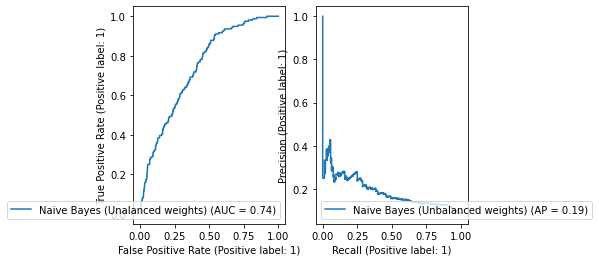

tox21-ar-mda-kb2-luc-antagonist-p2
              precision    recall  f1-score   support

           0       0.96      0.74      0.84      1694
           1       0.19      0.63      0.29       158

    accuracy                           0.73      1852
   macro avg       0.57      0.69      0.56      1852
weighted avg       0.89      0.73      0.79      1852



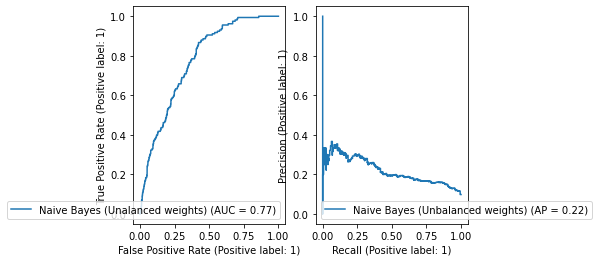

tox21-are-bla-p1
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1591
           1       0.15      0.65      0.24       126

    accuracy                           0.70      1717
   macro avg       0.55      0.68      0.53      1717
weighted avg       0.90      0.70      0.77      1717



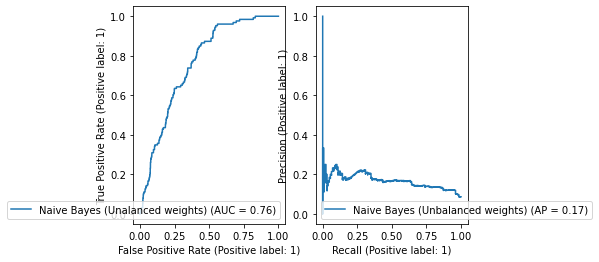

tox21-aromatase-p1
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      1696
           1       0.20      0.56      0.30       217

    accuracy                           0.70      1913
   macro avg       0.56      0.64      0.55      1913
weighted avg       0.84      0.70      0.75      1913



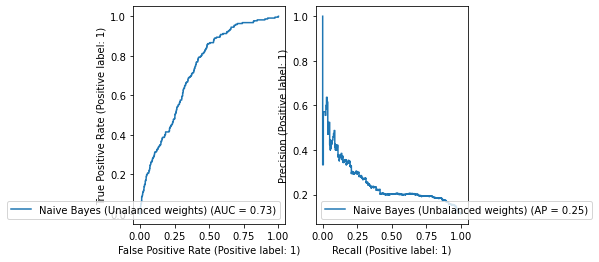

tox21-car-agonist-p1
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1652
           1       0.16      0.61      0.25       160

    accuracy                           0.68      1812
   macro avg       0.55      0.65      0.52      1812
weighted avg       0.88      0.68      0.75      1812



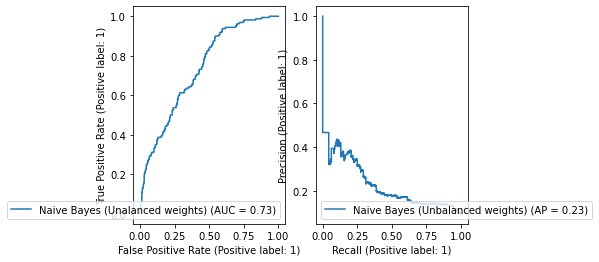

tox21-car-antagonist-p1
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1634
           1       0.21      0.68      0.32       188

    accuracy                           0.70      1822
   macro avg       0.58      0.69      0.56      1822
weighted avg       0.87      0.70      0.75      1822



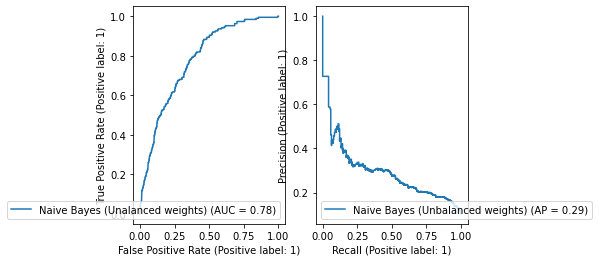

tox21-elg1-luc-agonist-p1
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      1793
           1       0.14      0.55      0.22       151

    accuracy                           0.70      1944
   macro avg       0.54      0.63      0.52      1944
weighted avg       0.89      0.70      0.77      1944



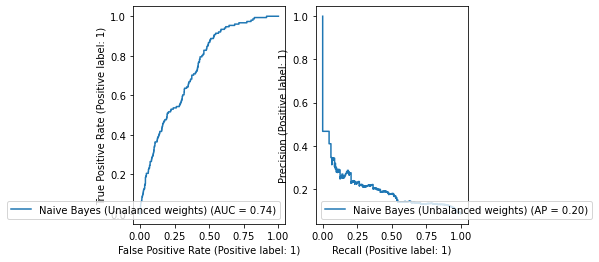

tox21-er-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1818
           1       0.09      0.60      0.16        89

    accuracy                           0.70      1907
   macro avg       0.53      0.65      0.49      1907
weighted avg       0.93      0.70      0.79      1907



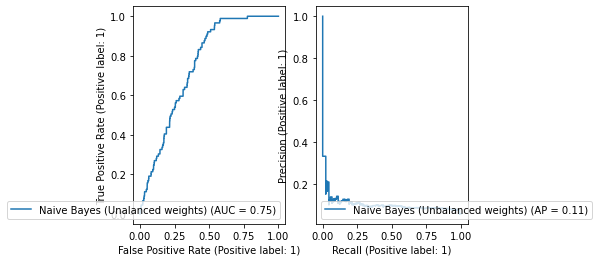

tox21-er-luc-bg1-4e2-agonist-p4
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1587
           1       0.22      0.61      0.32       191

    accuracy                           0.72      1778
   macro avg       0.58      0.67      0.57      1778
weighted avg       0.86      0.72      0.77      1778



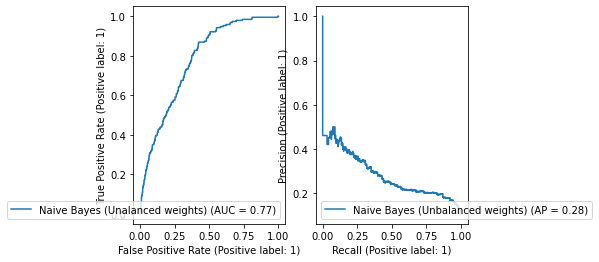

tox21-er-luc-bg1-4e2-antagonist-p1
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1810
           1       0.14      0.65      0.23       130

    accuracy                           0.70      1940
   macro avg       0.55      0.68      0.52      1940
weighted avg       0.91      0.70      0.78      1940



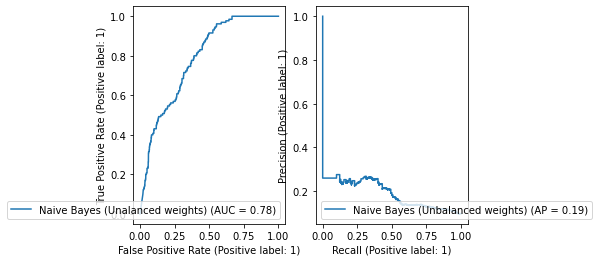

tox21-er-luc-bg1-4e2-antagonist-p2
              precision    recall  f1-score   support

           0       0.97      0.77      0.85      1746
           1       0.10      0.49      0.16        90

    accuracy                           0.75      1836
   macro avg       0.53      0.63      0.51      1836
weighted avg       0.92      0.75      0.82      1836



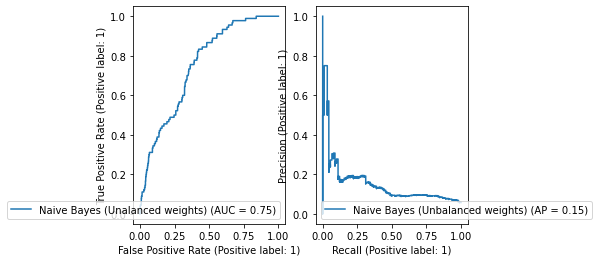

tox21-erb-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      1602
           1       0.22      0.72      0.34       183

    accuracy                           0.71      1785
   macro avg       0.59      0.72      0.58      1785
weighted avg       0.88      0.71      0.77      1785



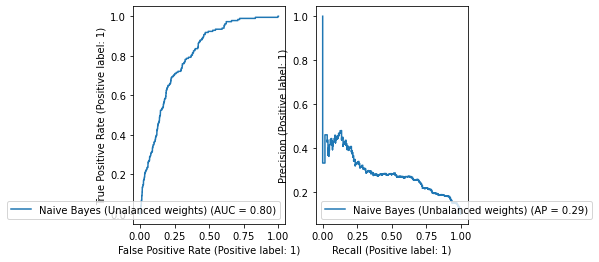

tox21-erb-bla-p1
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1492
           1       0.25      0.75      0.37       198

    accuracy                           0.70      1690
   macro avg       0.60      0.72      0.59      1690
weighted avg       0.87      0.70      0.75      1690



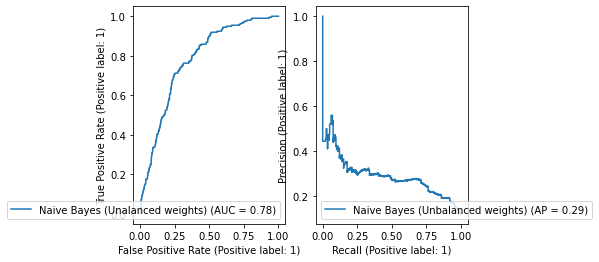

tox21-err-p1
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      1514
           1       0.27      0.69      0.39       231

    accuracy                           0.71      1745
   macro avg       0.60      0.70      0.60      1745
weighted avg       0.85      0.71      0.75      1745



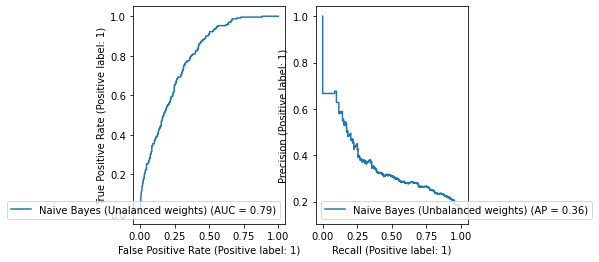

tox21-esre-bla-p1
              precision    recall  f1-score   support

           0       0.97      0.72      0.82      1540
           1       0.14      0.64      0.23       109

    accuracy                           0.71      1649
   macro avg       0.55      0.68      0.53      1649
weighted avg       0.91      0.71      0.78      1649



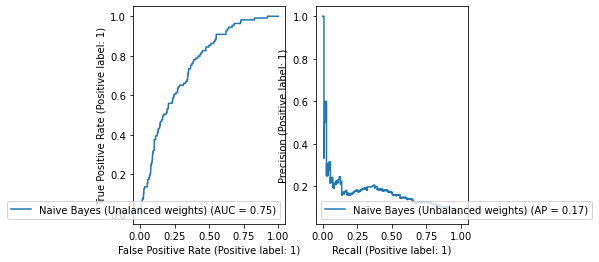

tox21-fxr-bla-agonist-p2
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1445
           1       0.16      0.71      0.26       111

    accuracy                           0.71      1556
   macro avg       0.56      0.71      0.54      1556
weighted avg       0.91      0.71      0.78      1556



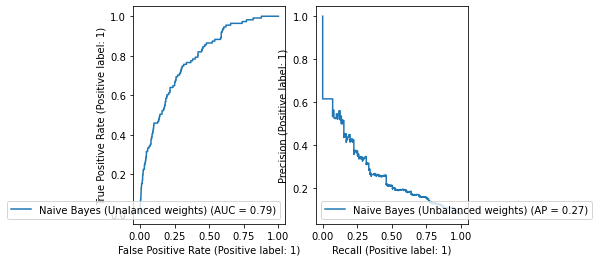

tox21-fxr-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.97      0.72      0.82      1516
           1       0.15      0.66      0.24       113

    accuracy                           0.72      1629
   macro avg       0.56      0.69      0.53      1629
weighted avg       0.91      0.72      0.78      1629



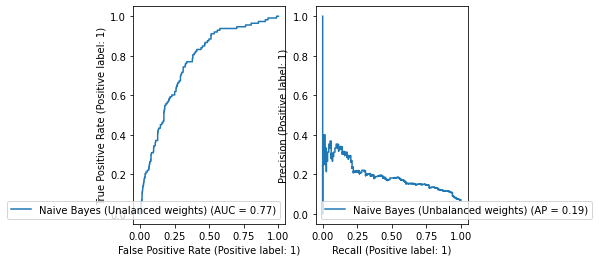

tox21-gh3-tre-antagonist-p1
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1399
           1       0.38      0.70      0.49       328

    accuracy                           0.73      1727
   macro avg       0.65      0.72      0.65      1727
weighted avg       0.81      0.73      0.75      1727



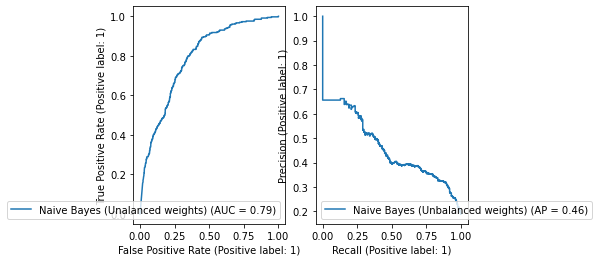

tox21-gr-hela-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.96      0.69      0.81      1742
           1       0.12      0.60      0.20       122

    accuracy                           0.69      1864
   macro avg       0.54      0.65      0.50      1864
weighted avg       0.91      0.69      0.77      1864



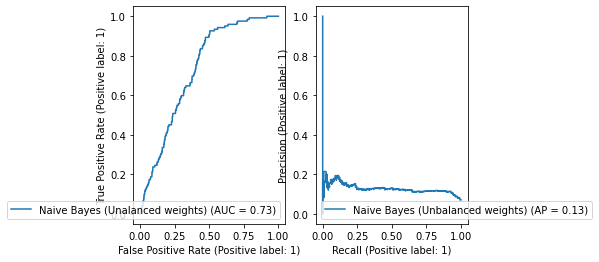

tox21-h2ax-cho-p2
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1574
           1       0.21      0.71      0.33       178

    accuracy                           0.70      1752
   macro avg       0.58      0.70      0.57      1752
weighted avg       0.88      0.70      0.76      1752



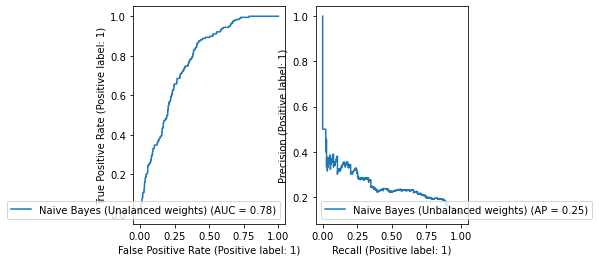

tox21-hdac-p1
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1846
           1       0.02      0.23      0.04        26

    accuracy                           0.86      1872
   macro avg       0.51      0.55      0.49      1872
weighted avg       0.97      0.86      0.91      1872



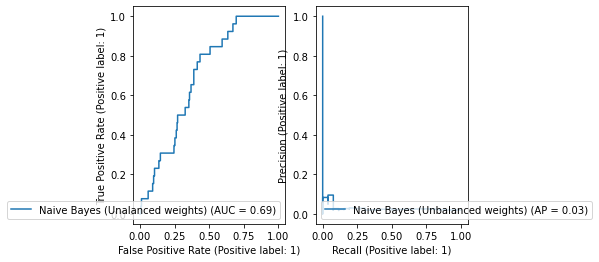

tox21-hre-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      1607
           1       0.18      0.68      0.28       146

    accuracy                           0.71      1753
   macro avg       0.57      0.70      0.55      1753
weighted avg       0.90      0.71      0.77      1753



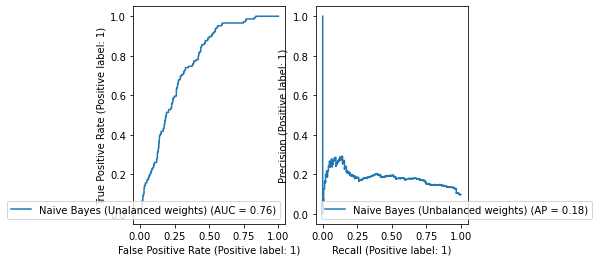

tox21-hse-bla-p1
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      1513
           1       0.12      0.67      0.20        89

    accuracy                           0.70      1602
   macro avg       0.55      0.69      0.51      1602
weighted avg       0.93      0.70      0.78      1602



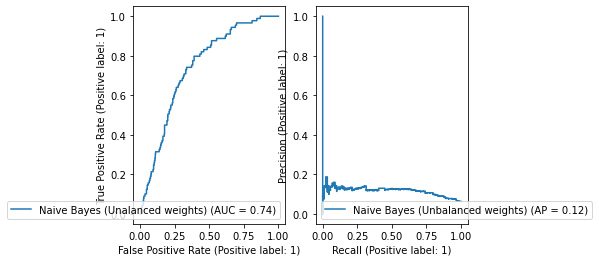

tox21-mitotox-p1
              precision    recall  f1-score   support

           0       0.96      0.74      0.84      1860
           1       0.09      0.46      0.14        97

    accuracy                           0.73      1957
   macro avg       0.52      0.60      0.49      1957
weighted avg       0.92      0.73      0.80      1957



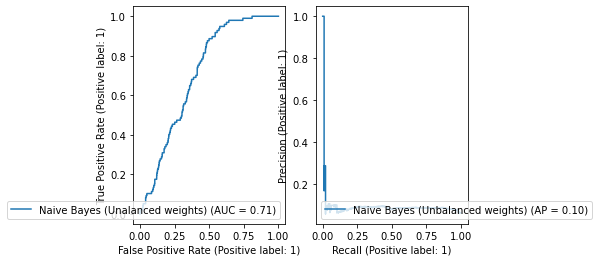

tox21-nfkb-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1548
           1       0.10      0.69      0.18        75

    accuracy                           0.70      1623
   macro avg       0.54      0.70      0.50      1623
weighted avg       0.94      0.70      0.79      1623



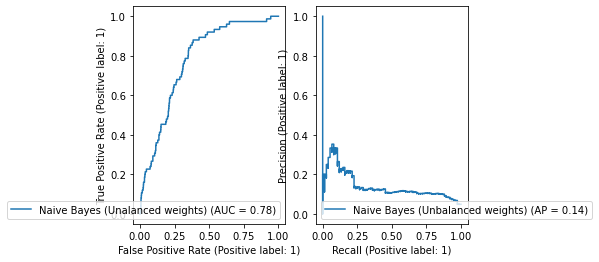

tox21-p53-bla-p1
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1824
           1       0.15      0.69      0.25       139

    accuracy                           0.71      1963
   macro avg       0.56      0.70      0.53      1963
weighted avg       0.91      0.71      0.78      1963



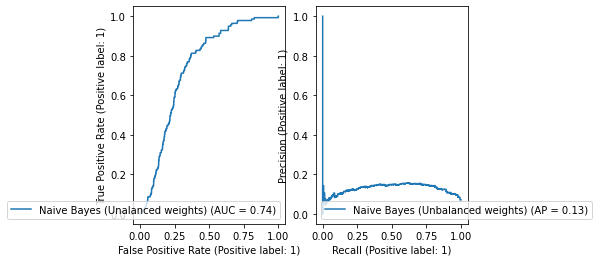

tox21-pgc-err-p1
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1530
           1       0.26      0.67      0.38       221

    accuracy                           0.72      1751
   macro avg       0.60      0.70      0.60      1751
weighted avg       0.85      0.72      0.76      1751



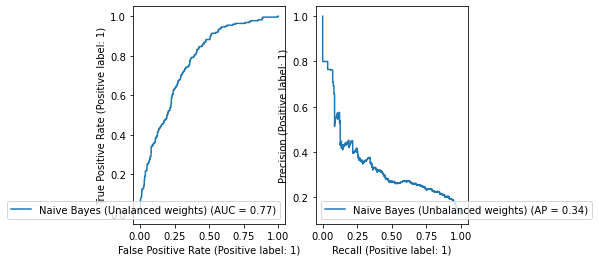

tox21-ppard-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      1440
           1       0.24      0.69      0.36       196

    accuracy                           0.70      1636
   macro avg       0.59      0.70      0.58      1636
weighted avg       0.86      0.70      0.75      1636



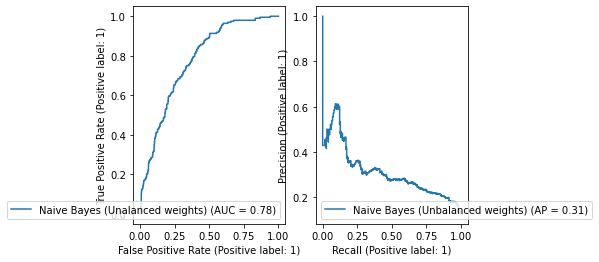

tox21-ppard-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1388
           1       0.21      0.68      0.32       149

    accuracy                           0.72      1537
   macro avg       0.58      0.70      0.57      1537
weighted avg       0.88      0.72      0.77      1537



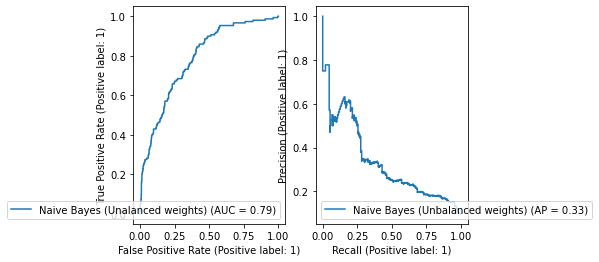

tox21-pparg-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      1371
           1       0.17      0.65      0.27       125

    accuracy                           0.71      1496
   macro avg       0.56      0.68      0.54      1496
weighted avg       0.89      0.71      0.77      1496



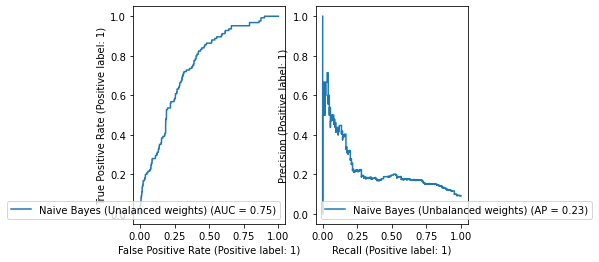

tox21-pr-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1369
           1       0.21      0.69      0.32       143

    accuracy                           0.72      1512
   macro avg       0.58      0.71      0.57      1512
weighted avg       0.89      0.72      0.78      1512



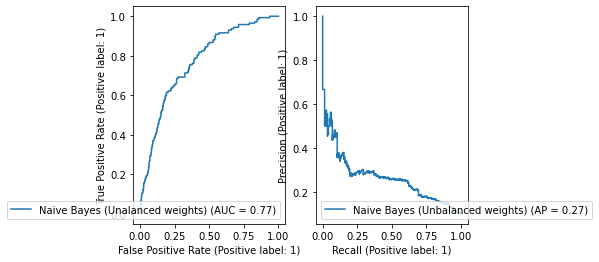

tox21-pr-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.94      0.69      0.80      1506
           1       0.18      0.62      0.28       168

    accuracy                           0.69      1674
   macro avg       0.56      0.66      0.54      1674
weighted avg       0.87      0.69      0.75      1674



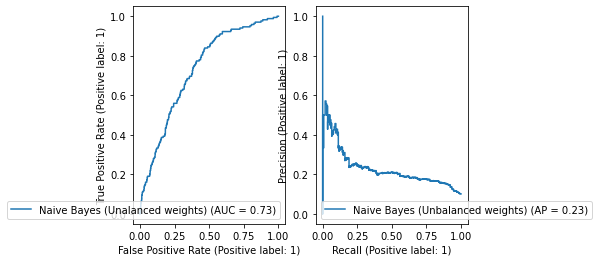

tox21-rar-antagonist-p2
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1712
           1       0.12      0.57      0.19        99

    accuracy                           0.74      1811
   macro avg       0.54      0.66      0.52      1811
weighted avg       0.92      0.74      0.81      1811



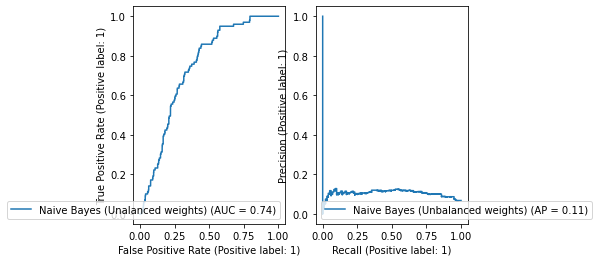

tox21-ror-cho-antagonist-p1
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1598
           1       0.15      0.64      0.24       119

    accuracy                           0.72      1717
   macro avg       0.56      0.68      0.53      1717
weighted avg       0.91      0.72      0.79      1717



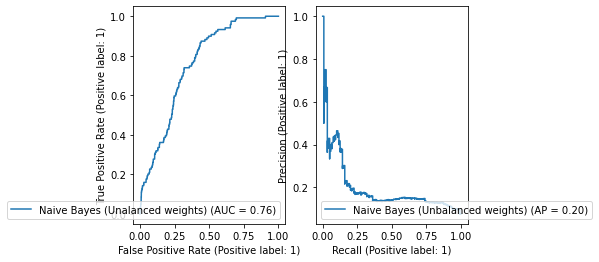

tox21-rxr-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1549
           1       0.23      0.73      0.35       197

    accuracy                           0.70      1746
   macro avg       0.59      0.71      0.58      1746
weighted avg       0.87      0.70      0.75      1746



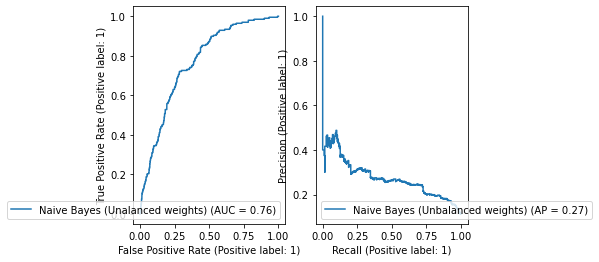

tox21-sbe-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      1783
           1       0.10      0.58      0.18        71

    accuracy                           0.79      1854
   macro avg       0.54      0.69      0.53      1854
weighted avg       0.95      0.79      0.86      1854



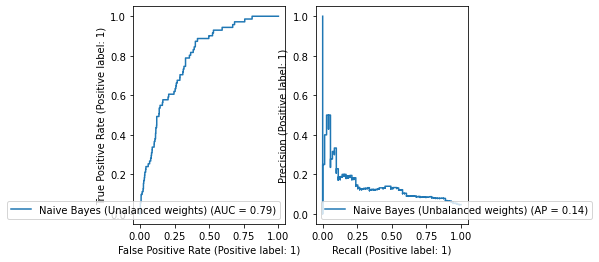

tox21-sbe-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1778
           1       0.07      0.49      0.12        61

    accuracy                           0.77      1839
   macro avg       0.52      0.63      0.49      1839
weighted avg       0.95      0.77      0.84      1839



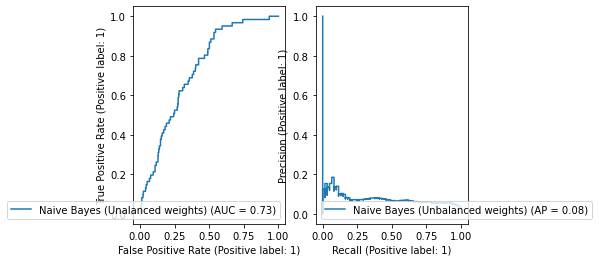

tox21-shh-3t3-gli3-agonist-p1
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1541
           1       0.24      0.62      0.34       232

    accuracy                           0.69      1773
   macro avg       0.58      0.66      0.57      1773
weighted avg       0.83      0.69      0.74      1773



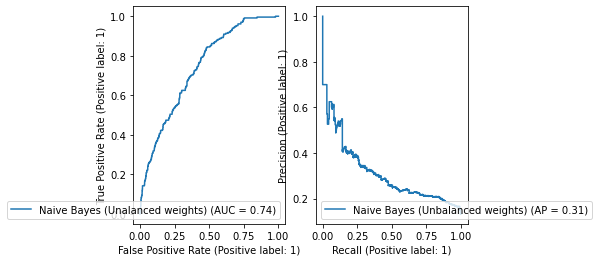

tox21-shh-3t3-gli3-antagonist-p1
              precision    recall  f1-score   support

           0       0.93      0.71      0.80      1544
           1       0.22      0.61      0.32       213

    accuracy                           0.69      1757
   macro avg       0.57      0.66      0.56      1757
weighted avg       0.84      0.69      0.74      1757



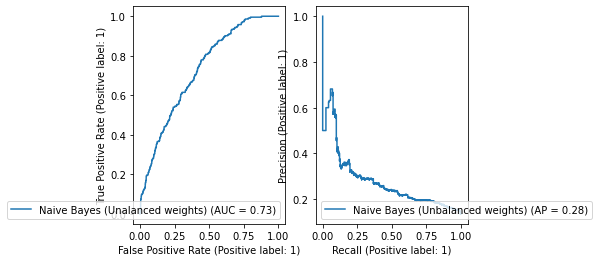

tox21-vdr-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1513
           1       0.21      0.72      0.32       171

    accuracy                           0.69      1684
   macro avg       0.58      0.70      0.56      1684
weighted avg       0.88      0.69      0.75      1684



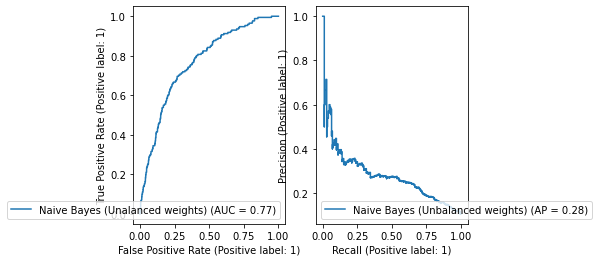

tox21-vdr-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      1426
           1       0.17      0.74      0.28       120

    accuracy                           0.70      1546
   macro avg       0.57      0.72      0.54      1546
weighted avg       0.91      0.70      0.77      1546



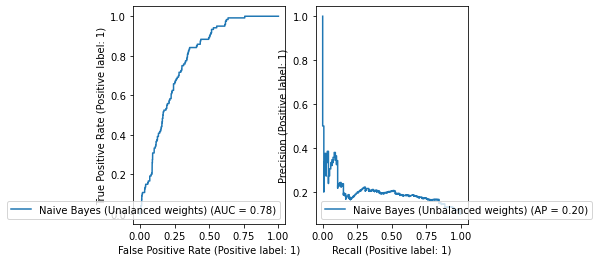

tox21-dt40-p1_653
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1211
           1       0.52      0.66      0.58       536

    accuracy                           0.71      1747
   macro avg       0.68      0.70      0.68      1747
weighted avg       0.74      0.71      0.72      1747



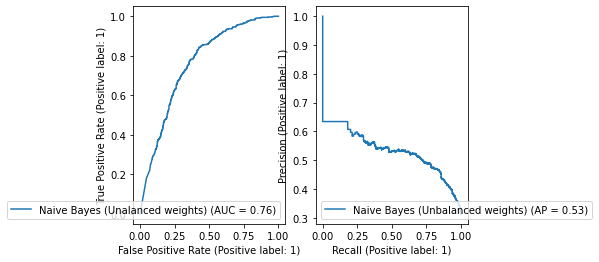

tox21-dt40-p1_100
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1223
           1       0.54      0.68      0.60       581

    accuracy                           0.71      1804
   macro avg       0.68      0.70      0.69      1804
weighted avg       0.73      0.71      0.72      1804



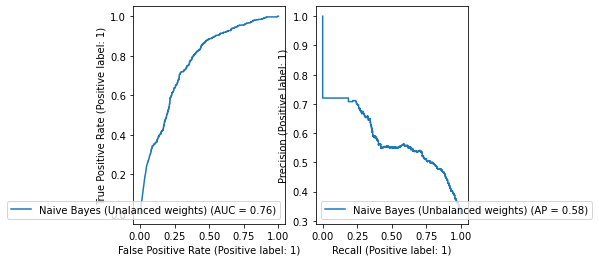

tox21-dt40-p1_657
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1169
           1       0.54      0.65      0.59       570

    accuracy                           0.71      1739
   macro avg       0.68      0.69      0.68      1739
weighted avg       0.72      0.71      0.71      1739



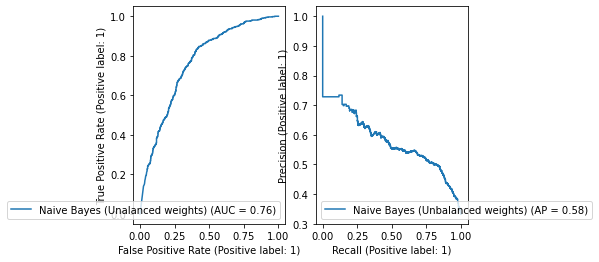

tox21-rt-viability-hepg2-p1
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      1728
           1       0.11      0.61      0.19       100

    accuracy                           0.72      1828
   macro avg       0.54      0.67      0.51      1828
weighted avg       0.92      0.72      0.80      1828



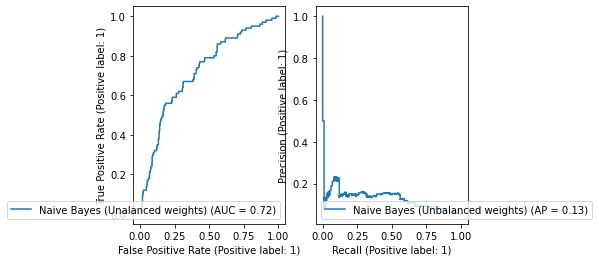

tox21-rt-viability-hek293-p1
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1436
           1       0.33      0.73      0.46       295

    accuracy                           0.71      1731
   macro avg       0.63      0.72      0.63      1731
weighted avg       0.83      0.71      0.74      1731



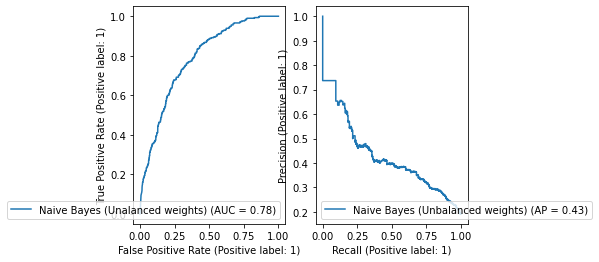

In [31]:
bal_accs = []
auc_scores = []
for i in range(len(df)):
    one_assay = df[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates()
    scaler = StandardScaler().fit(one_assay.iloc[:,2:])
    
    X = scaler.transform(one_assay.iloc[:,2:])
    y = label_encoder.fit_transform(one_assay.iloc[:,0])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    clf_unbalanced = BernoulliNB(alpha = 50).fit(X_train, y_train)

    y_pred_unbalanced = clf_unbalanced.predict(X_test)
    y_pred_decision = clf.predict_proba(X_test)
    print(one_assay.columns[1])
    print(classification_report(y_test,y_pred_unbalanced))
    
    bal_acc = balanced_accuracy_score(y_test,y_pred_unbalanced)
    bal_accs.append(bal_acc)
    
    auc = metrics.roc_auc_score(y_test, y_pred_decision[:, 1])
    auc_scores.append(auc)

    fig, (ax, ax1) = plt.subplots(1,2)
#     ax = plt.gca()

    RocCurveDisplay.from_estimator(clf_unbalanced, X_test, y_test,ax=ax,name="Naive Bayes (Unalanced weights)")
    
#     ax1 = plt.gca()

    PrecisionRecallDisplay.from_estimator(clf_unbalanced, X_test, y_test,ax=ax1,name="Naive Bayes (Unbalanced weights)")

    plt.show()


In [33]:
print(np.mean(bal_accs))
print(np.mean(auc_scores))

0.677398287324876
0.7350717680355149


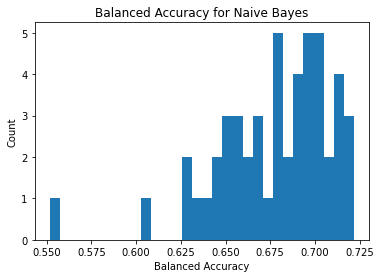

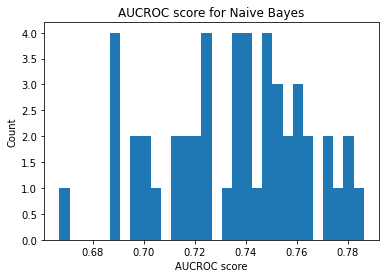

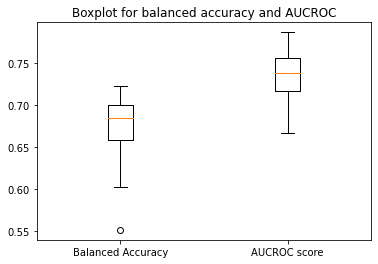

In [56]:
plt.hist(bal_accs, bins = 30)
plt.title('Balanced Accuracy for Naive Bayes')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores, bins = 30)
plt.title('AUCROC score for Naive Bayes')
plt.xlabel('AUCROC score')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs, auc_scores])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()

0.507036170026378
0.5898324667822068
              precision    recall  f1-score   support

           0       0.84      0.63      0.72      1447
           1       0.17      0.38      0.23       284

    accuracy                           0.59      1731
   macro avg       0.50      0.51      0.48      1731
weighted avg       0.73      0.59      0.64      1731

0.1660580460888052


NameError: name 'logistic_cv_unbalanced' is not defined

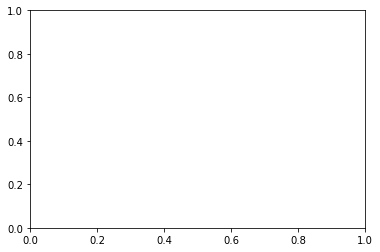

In [121]:
from sklearn import metrics
print(balanced_accuracy_score(y_test,y_pred_unbalanced))
print(metrics.accuracy_score(y_test,y_pred_unbalanced))
print(classification_report(y_test,y_pred_unbalanced))
print(metrics.average_precision_score(y_test, y_pred_unbalanced))

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_unbalanced)
metrics.auc(fpr, tpr)
ax = plt.gca()
RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_unbalanced)

### Balanced weight 
    

Standard scale with class weights

In [49]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.5394095529870492, 1: 6.843639575971731}

In [113]:
class_wt = []
for j in y_train:
    if j == 0:
        class_wt.append(class_weights[0])
    elif j == 1:
        class_wt.append(class_weights[1])
# print(class_wt.value_counts())
clf_balanced = BernoulliNB(alpha = 50).fit(np.log2([X_train]+1), y_train, sample_weight = class_wt)
len(y_train)

TypeError: can only concatenate list (not "int") to list

In [89]:
y_pred_balanced = clf_balanced.predict(X_test)
print(classification_report(y_test,y_pred_balanced))
print(balanced_accuracy_score(y_test, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.93      0.68      0.79      1436
           1       0.32      0.74      0.45       295

    accuracy                           0.69      1731
   macro avg       0.63      0.71      0.62      1731
weighted avg       0.83      0.69      0.73      1731

0.7127602568339549


In [87]:
print(clf_balanced.score(X_train, y_train))
print(clf_balanced.score(X_train, y_train, sample_weight = class_wt))
print(clf_balanced.score(X_test, y_test))

# create sample weight for testing set
class_wt_test = []
for i in y_test:
    if i == 0:
        class_wt_test.append(class_weights[0])
    elif i == 1:
        class_wt_test.append(class_weights[1])
print(clf_balanced.score(X_test, y_test, sample_weight = class_wt_test))

0.7020078000866676
0.7133454176147684
0.6932409012131716
0.713046920896018


log-transformed with class weights, FAILED, many nans and 0s after transformed

Run all 50 assays

SMILES
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      1429
           1       0.15      0.70      0.24       114

    accuracy                           0.67      1543
   macro avg       0.56      0.69      0.52      1543
weighted avg       0.91      0.67      0.75      1543



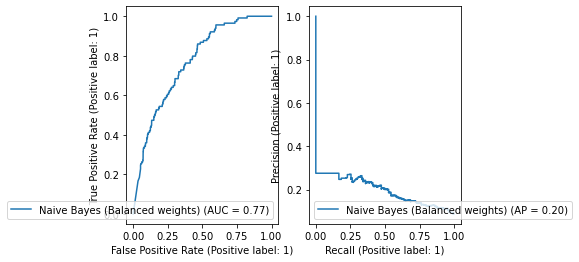

SMILES
              precision    recall  f1-score   support

           0       0.98      0.64      0.77      1405
           1       0.10      0.72      0.17        76

    accuracy                           0.64      1481
   macro avg       0.54      0.68      0.47      1481
weighted avg       0.93      0.64      0.74      1481



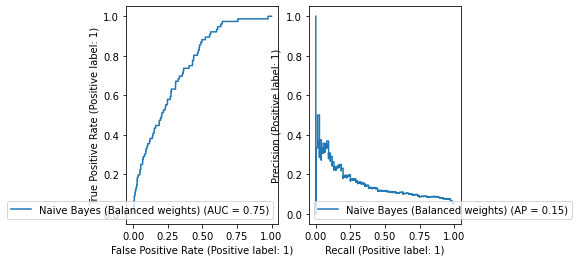

SMILES
              precision    recall  f1-score   support

           0       0.94      0.64      0.77      1381
           1       0.16      0.64      0.25       146

    accuracy                           0.64      1527
   macro avg       0.55      0.64      0.51      1527
weighted avg       0.87      0.64      0.72      1527



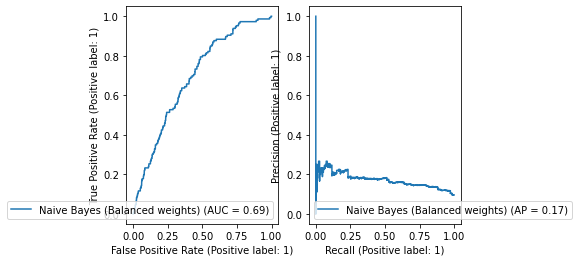

SMILES
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1331
           1       0.20      0.78      0.32       153

    accuracy                           0.66      1484
   macro avg       0.58      0.71      0.55      1484
weighted avg       0.88      0.66      0.72      1484



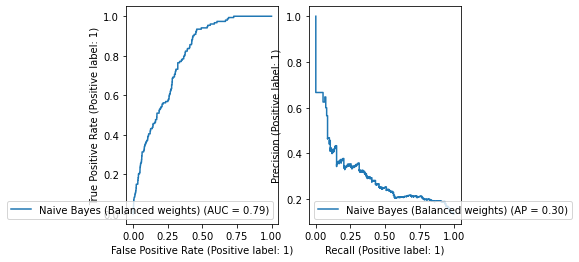

SMILES
              precision    recall  f1-score   support

           0       0.97      0.63      0.77      1469
           1       0.13      0.71      0.21       108

    accuracy                           0.64      1577
   macro avg       0.55      0.67      0.49      1577
weighted avg       0.91      0.64      0.73      1577



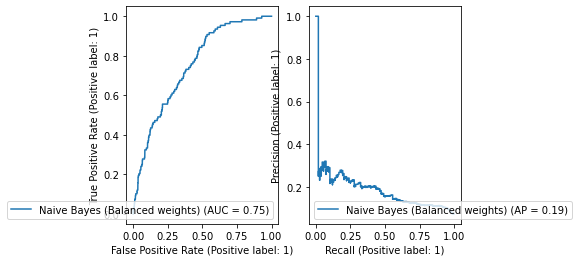

SMILES
              precision    recall  f1-score   support

           0       0.96      0.66      0.79      1397
           1       0.15      0.70      0.24       116

    accuracy                           0.67      1513
   macro avg       0.56      0.68      0.51      1513
weighted avg       0.90      0.67      0.74      1513



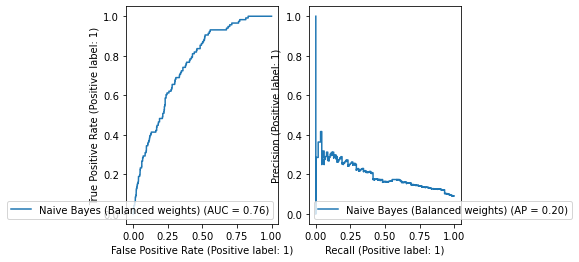

SMILES
              precision    recall  f1-score   support

           0       0.96      0.65      0.77      1282
           1       0.15      0.72      0.25       113

    accuracy                           0.65      1395
   macro avg       0.56      0.68      0.51      1395
weighted avg       0.90      0.65      0.73      1395



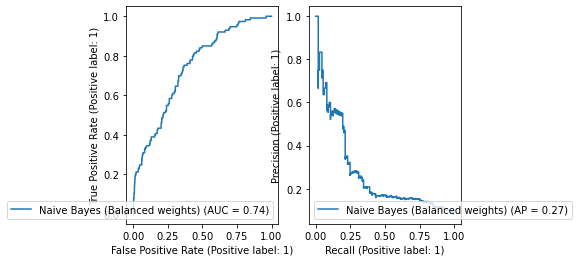

SMILES
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1347
           1       0.19      0.62      0.29       191

    accuracy                           0.63      1538
   macro avg       0.56      0.63      0.52      1538
weighted avg       0.83      0.63      0.69      1538



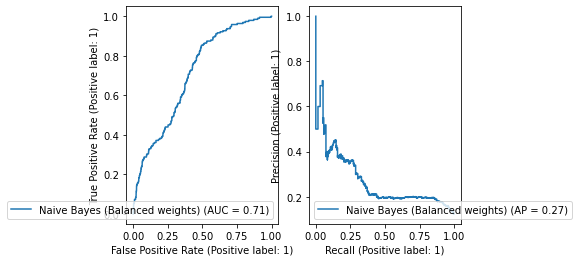

SMILES
              precision    recall  f1-score   support

           0       0.96      0.63      0.77      1354
           1       0.17      0.76      0.28       132

    accuracy                           0.65      1486
   macro avg       0.57      0.70      0.52      1486
weighted avg       0.89      0.65      0.72      1486



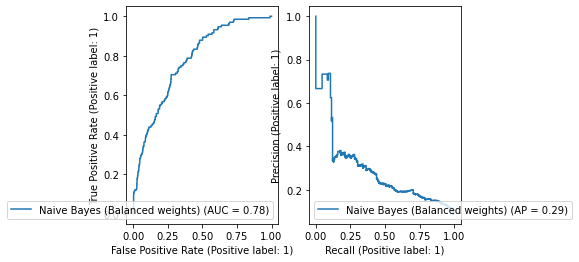

SMILES
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1340
           1       0.19      0.64      0.29       153

    accuracy                           0.68      1493
   macro avg       0.56      0.66      0.54      1493
weighted avg       0.87      0.68      0.74      1493



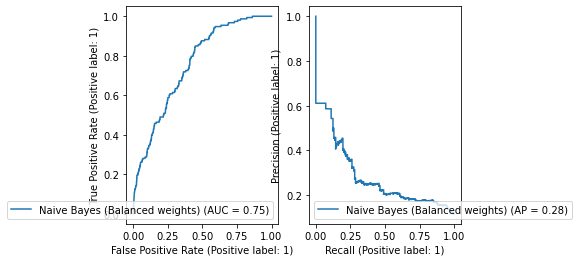

SMILES
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      1444
           1       0.14      0.73      0.23       112

    accuracy                           0.65      1556
   macro avg       0.55      0.69      0.51      1556
weighted avg       0.91      0.65      0.74      1556



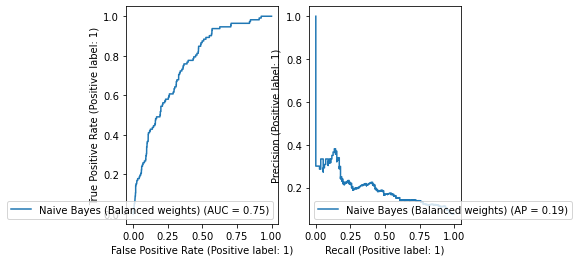

SMILES
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1479
           1       0.10      0.79      0.18        73

    accuracy                           0.65      1552
   macro avg       0.54      0.72      0.48      1552
weighted avg       0.94      0.65      0.75      1552



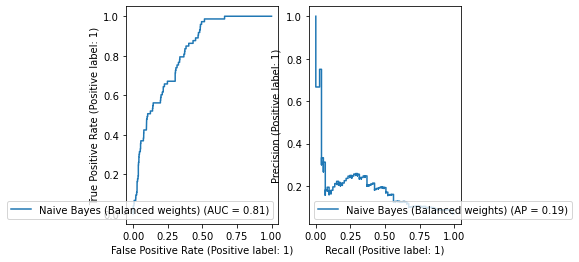

SMILES
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      1295
           1       0.20      0.67      0.31       165

    accuracy                           0.66      1460
   macro avg       0.57      0.67      0.54      1460
weighted avg       0.86      0.66      0.72      1460



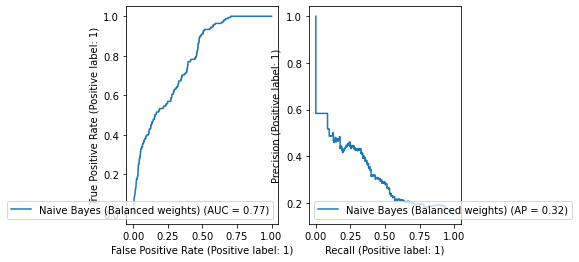

SMILES
              precision    recall  f1-score   support

           0       0.97      0.70      0.82      1459
           1       0.11      0.64      0.19        83

    accuracy                           0.70      1542
   macro avg       0.54      0.67      0.50      1542
weighted avg       0.93      0.70      0.78      1542



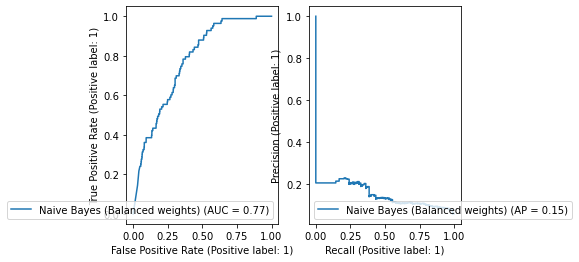

SMILES
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1417
           1       0.11      0.72      0.19        79

    accuracy                           0.67      1496
   macro avg       0.54      0.70      0.49      1496
weighted avg       0.93      0.67      0.76      1496



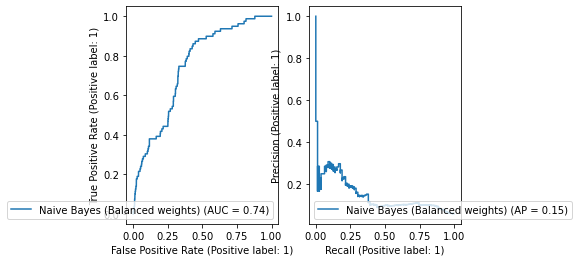

SMILES
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1304
           1       0.23      0.75      0.36       159

    accuracy                           0.70      1463
   macro avg       0.60      0.73      0.58      1463
weighted avg       0.88      0.70      0.76      1463



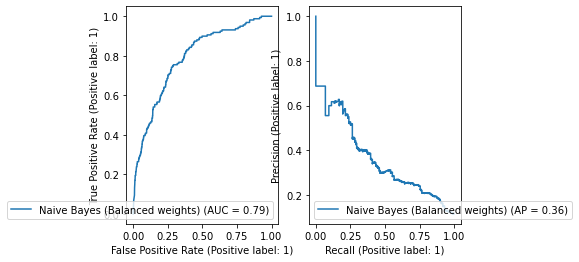

SMILES
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      1240
           1       0.24      0.83      0.38       155

    accuracy                           0.70      1395
   macro avg       0.61      0.75      0.59      1395
weighted avg       0.89      0.70      0.75      1395



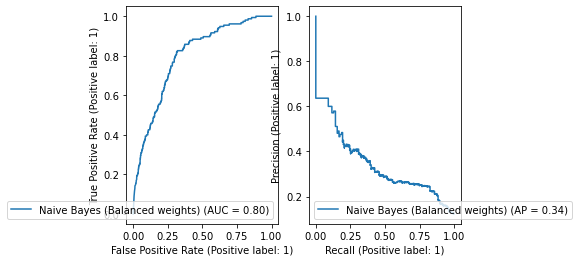

SMILES
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1248
           1       0.26      0.71      0.38       192

    accuracy                           0.69      1440
   macro avg       0.60      0.70      0.58      1440
weighted avg       0.85      0.69      0.74      1440



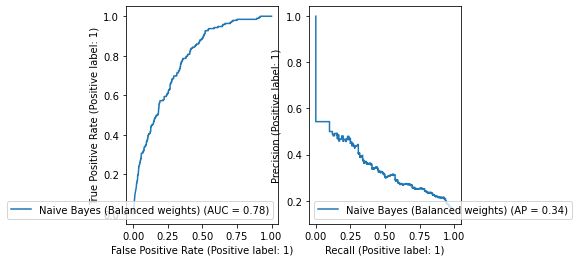

SMILES
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1279
           1       0.10      0.67      0.18        78

    accuracy                           0.64      1357
   macro avg       0.54      0.65      0.47      1357
weighted avg       0.92      0.64      0.74      1357



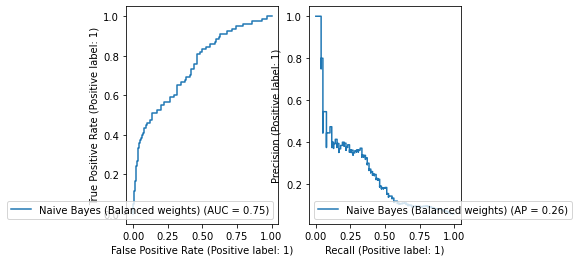

SMILES
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      1178
           1       0.19      0.78      0.31       115

    accuracy                           0.69      1293
   macro avg       0.58      0.73      0.55      1293
weighted avg       0.90      0.69      0.76      1293



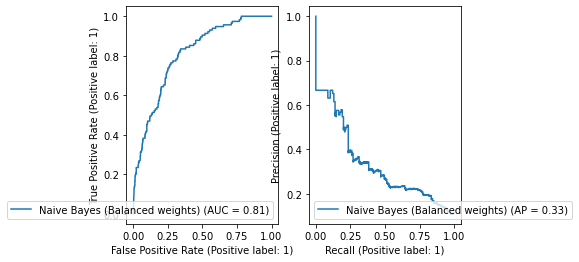

SMILES
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1252
           1       0.13      0.80      0.23        85

    accuracy                           0.66      1337
   macro avg       0.56      0.73      0.51      1337
weighted avg       0.93      0.66      0.75      1337



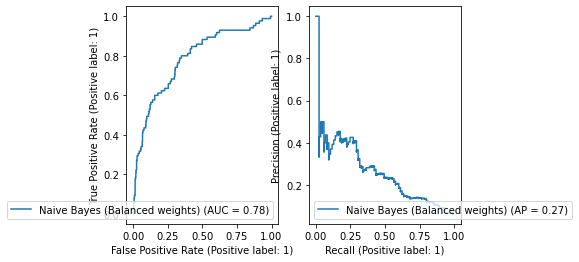

SMILES
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1159
           1       0.36      0.71      0.48       256

    accuracy                           0.72      1415
   macro avg       0.64      0.72      0.65      1415
weighted avg       0.82      0.72      0.75      1415



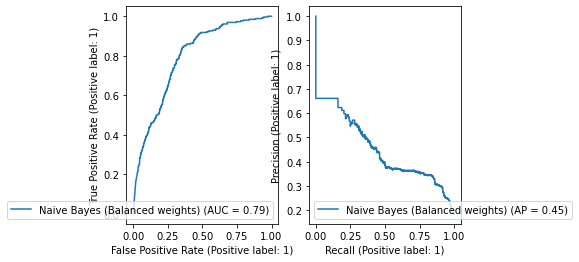

SMILES
              precision    recall  f1-score   support

           0       0.97      0.65      0.77      1406
           1       0.12      0.69      0.20        94

    accuracy                           0.65      1500
   macro avg       0.54      0.67      0.49      1500
weighted avg       0.92      0.65      0.74      1500



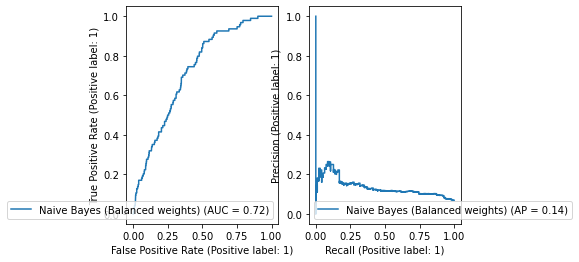

SMILES
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      1278
           1       0.24      0.73      0.36       174

    accuracy                           0.69      1452
   macro avg       0.59      0.71      0.58      1452
weighted avg       0.86      0.69      0.74      1452



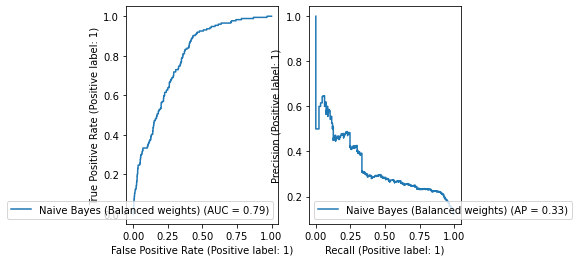

SMILES
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1487
           1       0.04      0.71      0.08        31

    accuracy                           0.66      1518
   macro avg       0.52      0.68      0.43      1518
weighted avg       0.97      0.66      0.77      1518



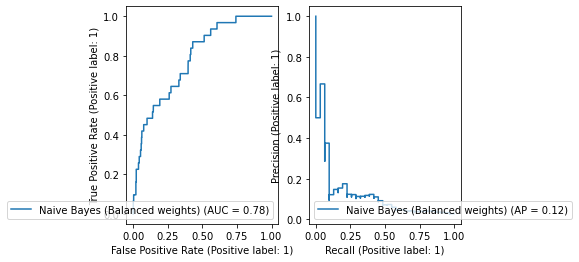

SMILES
              precision    recall  f1-score   support

           0       0.96      0.66      0.79      1308
           1       0.19      0.75      0.30       134

    accuracy                           0.67      1442
   macro avg       0.58      0.71      0.54      1442
weighted avg       0.89      0.67      0.74      1442



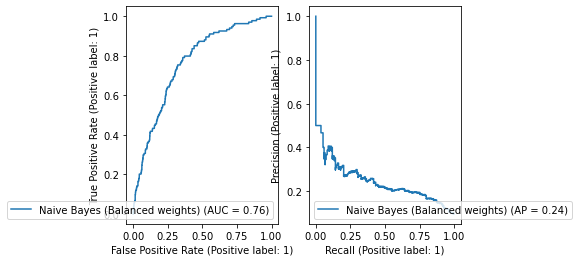

SMILES
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      1220
           1       0.12      0.65      0.20        88

    accuracy                           0.65      1308
   macro avg       0.54      0.65      0.49      1308
weighted avg       0.91      0.65      0.74      1308



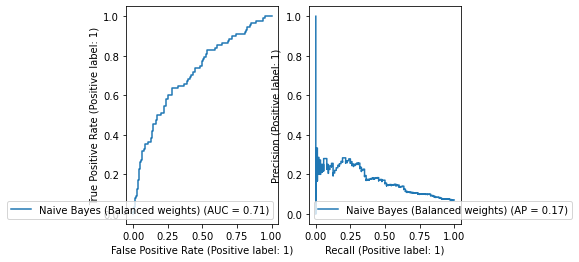

SMILES
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1493
           1       0.08      0.64      0.15        78

    accuracy                           0.64      1571
   macro avg       0.53      0.64      0.46      1571
weighted avg       0.93      0.64      0.74      1571



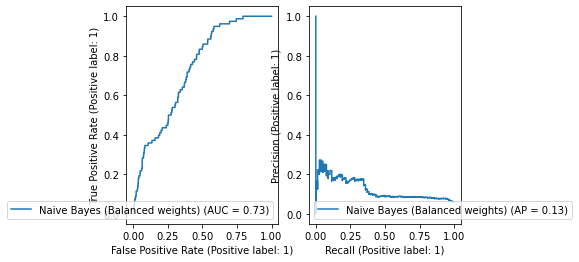

SMILES
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1260
           1       0.10      0.69      0.17        71

    accuracy                           0.64      1331
   macro avg       0.54      0.66      0.47      1331
weighted avg       0.93      0.64      0.74      1331



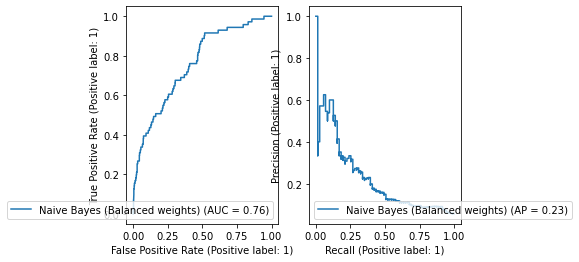

SMILES
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      1465
           1       0.14      0.75      0.23       103

    accuracy                           0.68      1568
   macro avg       0.56      0.71      0.51      1568
weighted avg       0.92      0.68      0.76      1568



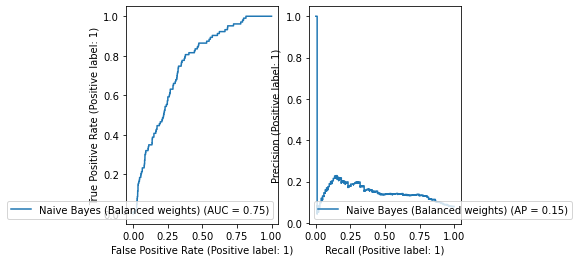

SMILES
              precision    recall  f1-score   support

           0       0.95      0.67      0.79      1265
           1       0.25      0.75      0.38       184

    accuracy                           0.68      1449
   macro avg       0.60      0.71      0.58      1449
weighted avg       0.86      0.68      0.74      1449



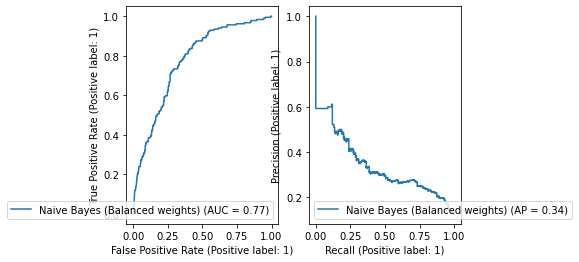

SMILES
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1180
           1       0.27      0.78      0.40       170

    accuracy                           0.70      1350
   macro avg       0.61      0.74      0.60      1350
weighted avg       0.87      0.70      0.75      1350



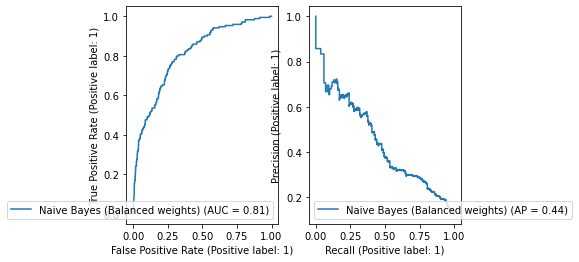

SMILES
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1156
           1       0.19      0.76      0.31       119

    accuracy                           0.68      1275
   macro avg       0.58      0.72      0.55      1275
weighted avg       0.89      0.68      0.75      1275



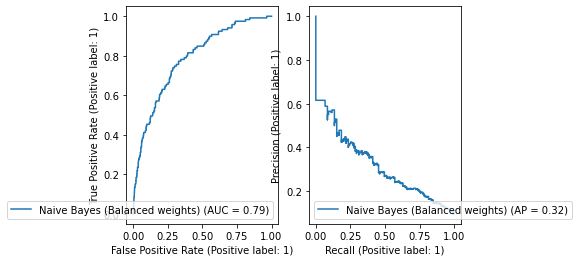

SMILES
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      1147
           1       0.17      0.75      0.28       106

    accuracy                           0.67      1253
   macro avg       0.57      0.71      0.53      1253
weighted avg       0.90      0.67      0.74      1253



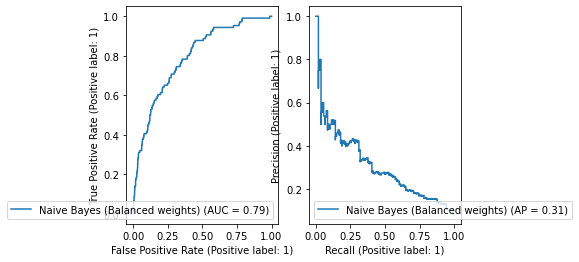

SMILES
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1161
           1       0.18      0.73      0.29       109

    accuracy                           0.69      1270
   macro avg       0.57      0.71      0.54      1270
weighted avg       0.90      0.69      0.75      1270



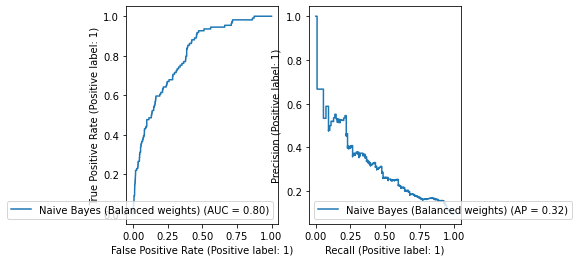

SMILES
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      1245
           1       0.19      0.65      0.29       149

    accuracy                           0.66      1394
   macro avg       0.56      0.66      0.53      1394
weighted avg       0.86      0.66      0.72      1394



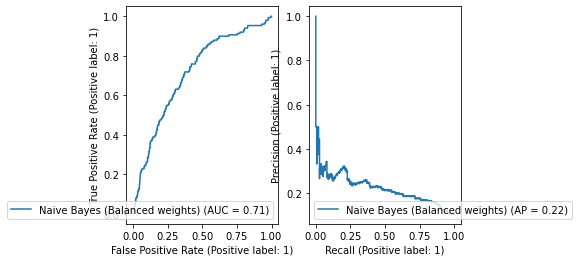

SMILES
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      1409
           1       0.09      0.64      0.16        76

    accuracy                           0.65      1485
   macro avg       0.53      0.65      0.47      1485
weighted avg       0.93      0.65      0.75      1485



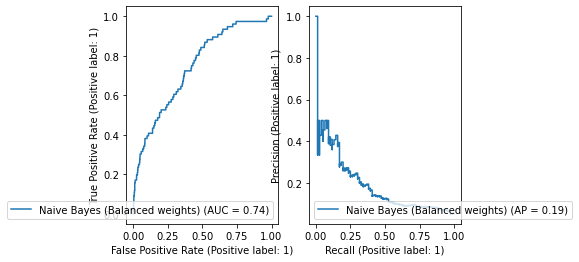

SMILES
              precision    recall  f1-score   support

           0       0.97      0.63      0.77      1320
           1       0.11      0.67      0.19        89

    accuracy                           0.64      1409
   macro avg       0.54      0.65      0.48      1409
weighted avg       0.91      0.64      0.73      1409



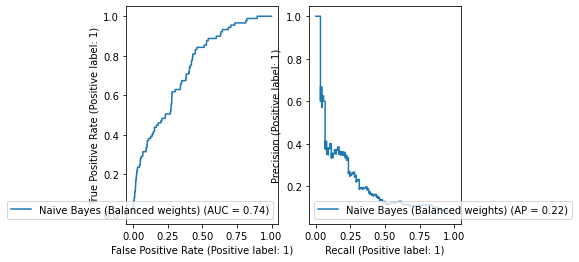

SMILES
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      1249
           1       0.25      0.74      0.37       191

    accuracy                           0.67      1440
   macro avg       0.60      0.70      0.57      1440
weighted avg       0.85      0.67      0.72      1440



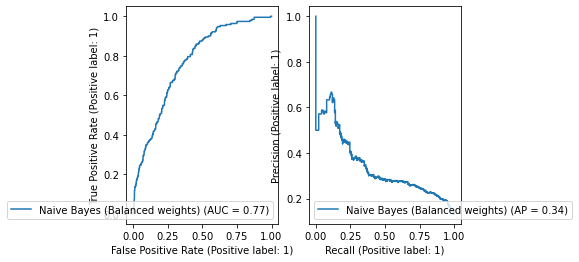

SMILES
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1460
           1       0.06      0.64      0.11        50

    accuracy                           0.65      1510
   macro avg       0.52      0.64      0.44      1510
weighted avg       0.95      0.65      0.76      1510



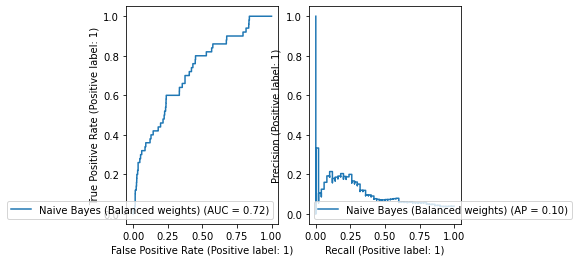

SMILES
              precision    recall  f1-score   support

           0       0.99      0.61      0.76      1442
           1       0.07      0.80      0.14        56

    accuracy                           0.62      1498
   macro avg       0.53      0.71      0.45      1498
weighted avg       0.95      0.62      0.73      1498



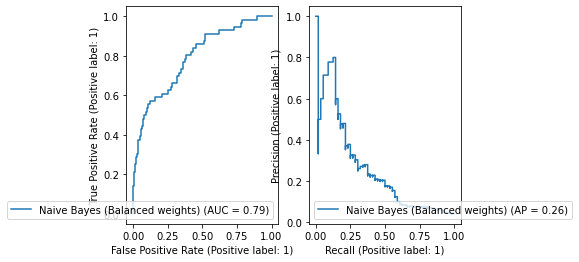

SMILES
              precision    recall  f1-score   support

           0       0.95      0.67      0.79      1282
           1       0.24      0.74      0.36       175

    accuracy                           0.68      1457
   macro avg       0.59      0.71      0.57      1457
weighted avg       0.86      0.68      0.73      1457



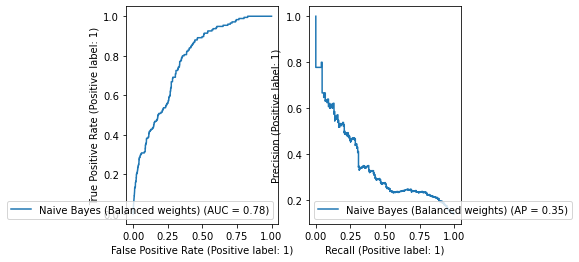

SMILES
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      1283
           1       0.21      0.67      0.32       171

    accuracy                           0.66      1454
   macro avg       0.57      0.67      0.55      1454
weighted avg       0.85      0.66      0.72      1454



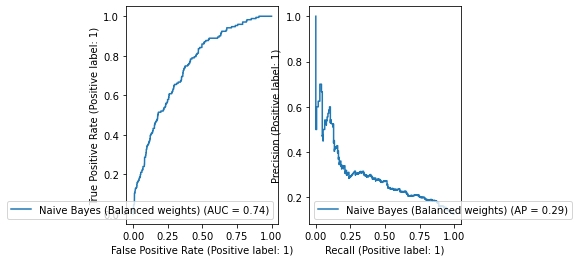

SMILES
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1222
           1       0.21      0.66      0.32       159

    accuracy                           0.68      1381
   macro avg       0.58      0.67      0.55      1381
weighted avg       0.86      0.68      0.73      1381



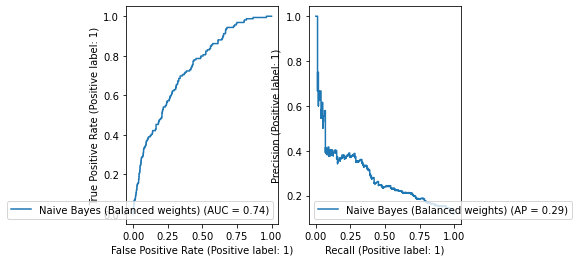

SMILES
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1151
           1       0.20      0.74      0.32       130

    accuracy                           0.68      1281
   macro avg       0.58      0.71      0.55      1281
weighted avg       0.88      0.68      0.74      1281



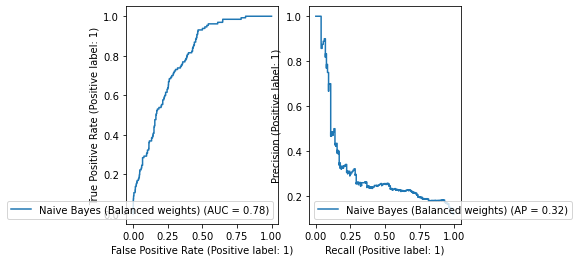

SMILES
              precision    recall  f1-score   support

           0       0.84      0.74      0.78      1010
           1       0.53      0.68      0.59       442

    accuracy                           0.72      1452
   macro avg       0.68      0.71      0.69      1452
weighted avg       0.75      0.72      0.73      1452



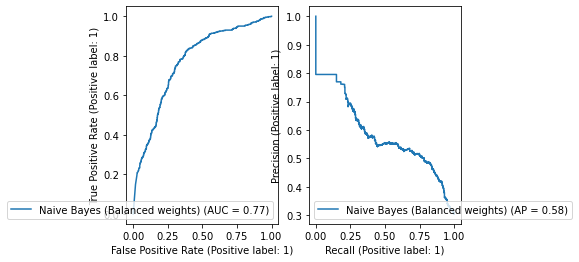

SMILES
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       991
           1       0.55      0.66      0.60       489

    accuracy                           0.71      1480
   macro avg       0.68      0.70      0.69      1480
weighted avg       0.73      0.71      0.71      1480



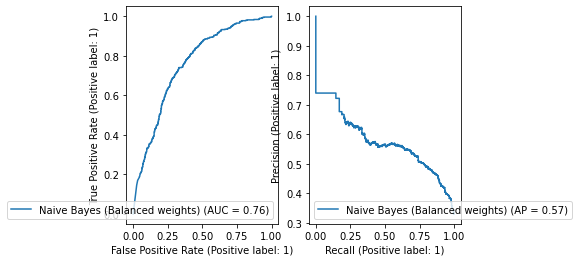

SMILES
              precision    recall  f1-score   support

           0       0.80      0.71      0.76       974
           1       0.51      0.63      0.57       466

    accuracy                           0.69      1440
   macro avg       0.66      0.67      0.66      1440
weighted avg       0.71      0.69      0.69      1440



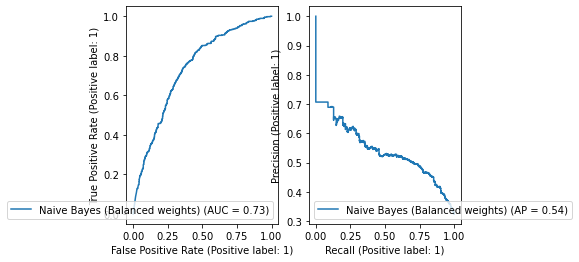

SMILES
              precision    recall  f1-score   support

           0       0.97      0.66      0.79      1402
           1       0.11      0.70      0.19        86

    accuracy                           0.67      1488
   macro avg       0.54      0.68      0.49      1488
weighted avg       0.92      0.67      0.76      1488



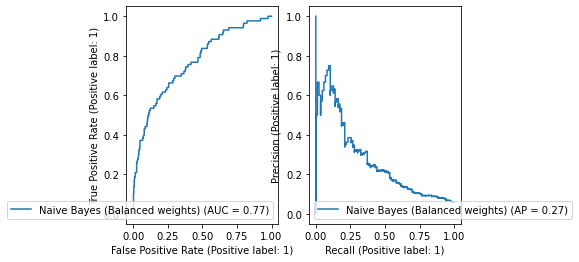

SMILES
              precision    recall  f1-score   support

           0       0.93      0.69      0.80      1209
           1       0.31      0.72      0.43       226

    accuracy                           0.70      1435
   macro avg       0.62      0.71      0.61      1435
weighted avg       0.83      0.70      0.74      1435



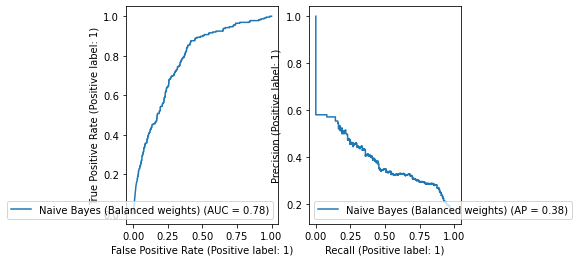

In [7]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

bal_accs_w = []
auc_scores_w = []
for i in range(len(df)):
    one_assay = df[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates()
    scaler = StandardScaler().fit(one_assay.iloc[:,2:])
    
    X = scaler.transform(one_assay.iloc[:,2:])
    y = label_encoder.fit_transform(one_assay.iloc[:,0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    
    class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
    class_weights = dict(zip(np.unique(y_train), class_weights))
    
    class_wt = []
    for j in y_train:
        if j == 0:
            class_wt.append(class_weights[0])
        elif j == 1:
            class_wt.append(class_weights[1])
    
    clf_balanced = BernoulliNB(alpha = 50).fit(X_train, y_train, sample_weight = class_wt)

    y_pred_balanced = clf_balanced.predict(X_test)
    y_pred_prob = clf_balanced.predict_proba(X_test)
    print(one_assay.columns[1])
    print(classification_report(y_test,y_pred_balanced))
    
    bal_acc = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc)
    
    auc = metrics.roc_auc_score(y_test, y_pred_prob[:, 1])
    auc_scores_w.append(auc)

    fig, (ax, ax1) = plt.subplots(1,2)
#     ax = plt.gca()

    RocCurveDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax,name="Naive Bayes (Balanced weights)")
    
#     ax1 = plt.gca()

    PrecisionRecallDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax1,name="Naive Bayes (Balanced weights)")

    plt.show()


In [8]:
print(np.mean(bal_accs_w))
print(np.mean(auc_scores_w))

0.6883136595133179
0.7619314619711575


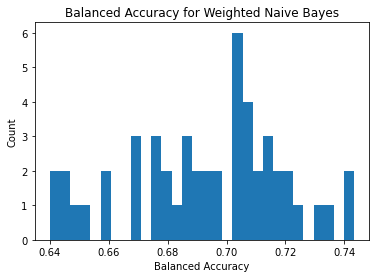

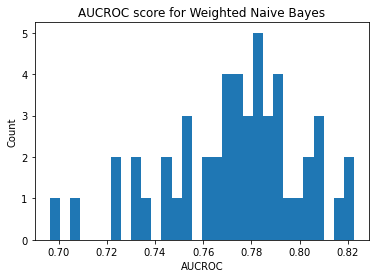

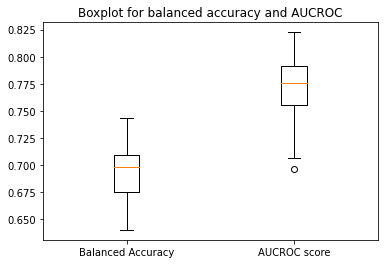

In [57]:
plt.hist(bal_accs_w, bins = 30)
plt.title('Balanced Accuracy for Weighted Naive Bayes')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores_w, bins = 30)
plt.title('AUCROC score for Weighted Naive Bayes')
plt.xlabel('AUCROC')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs_w, auc_scores_w])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()

In [120]:
print(balanced_accuracy_score(y_test,y_pred_balanced))
print(metrics.accuracy_score(y_test,y_pred_balanced))
print(classification_report(y_test,y_pred_balanced))
print(metrics.average_precision_score(y_test, y_pred_balanced))
print(metrics.roc_auc_score(y_test, y_pred_balanced))

0.7243763201183604
0.7047949162333911
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1447
           1       0.33      0.75      0.46       284

    accuracy                           0.70      1731
   macro avg       0.63      0.72      0.63      1731
weighted avg       0.84      0.70      0.74      1731

0.2866276344436852
0.7243763201183605


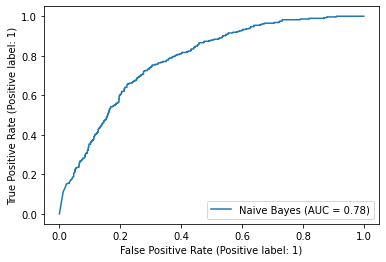

In [104]:
ax = plt.gca()
RocCurveDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax,name="Naive Bayes")
plt.show()

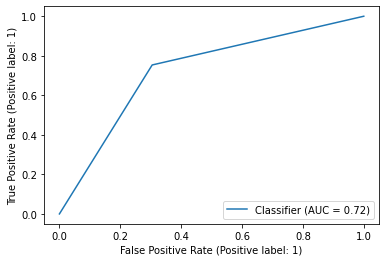

In [105]:
RocCurveDisplay.from_predictions(y_test, y_pred_balanced)

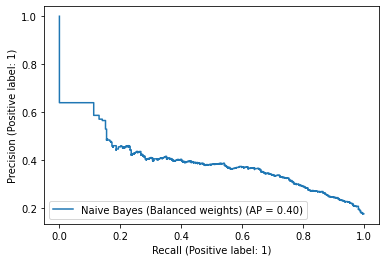

In [106]:
ax = plt.gca()
PrecisionRecallDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax,name="Naive Bayes (Balanced weights)")


In [108]:
print(np.mean(bal_accs))
print(np.mean(bal_accs_w))

0.677398287324876
0.6930723030380814


As a summary so far, compare with unbalanced naive bayesian model, the balanced accuracy increased about 2 percent, the average balanced accuracy is 69.31%. Tried log-transformed the features, however, many of them are giving nans and zeros, even after +1, so we stay with standard scaler.

## Pymc data with naive bayesian with priors

In [21]:
df = pd.read_csv('pymc_data.csv')
df_1 = df.iloc[:100, :5]
df_1['outcome'] = df.iloc[:100, -6]
df_2 = df.iloc[100:200, :5]
df_2['outcome'] = df.iloc[100:200, -6]
df_3 = df.iloc[200:300, :5]
df_3['outcome'] = df.iloc[200:300, -6]
df_4 = df.iloc[300:, :5]
df_4['outcome'] = df.iloc[300:, -6]
df_list = [df_1, df_2, df_3, df_4]

In [36]:
one_assay = df_list[3]
one_assay = one_assay.drop(one_assay.columns[0],axis=1)
# scaler = StandardScaler().fit(one_assay.iloc[:,:4])
    
# X = scaler.transform(one_assay.iloc[:,:4])
# y = label_encoder.fit_transform(one_assay.iloc[:,4])
one_assay.iloc[:,4].value_counts()

0.0    50
1.0    50
Name: outcome, dtype: int64

0
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.62      0.77         8

    accuracy                           0.85        20
   macro avg       0.90      0.81      0.83        20
weighted avg       0.88      0.85      0.84        20



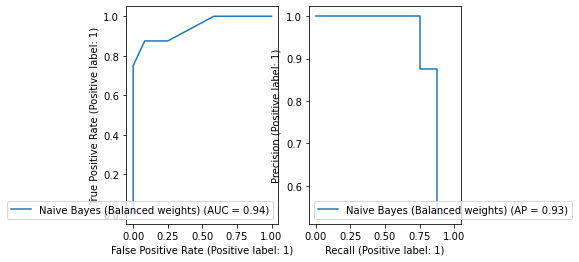

1
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.67      0.75      0.71         8

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20



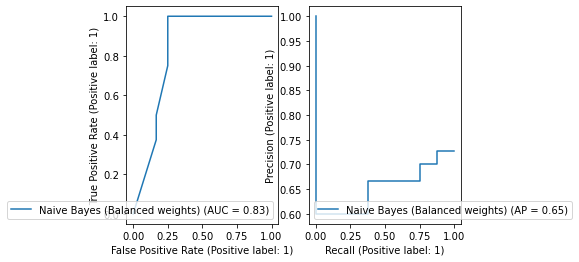

2
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.56      0.62      0.59         8

    accuracy                           0.65        20
   macro avg       0.64      0.65      0.64        20
weighted avg       0.66      0.65      0.65        20



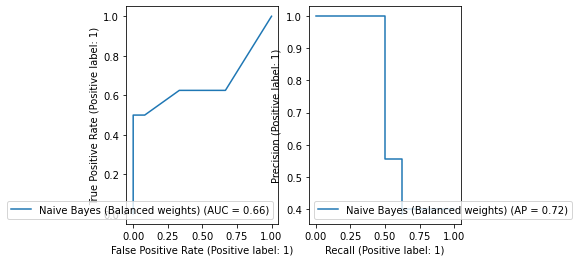

3
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.67      0.75      0.71         8

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20



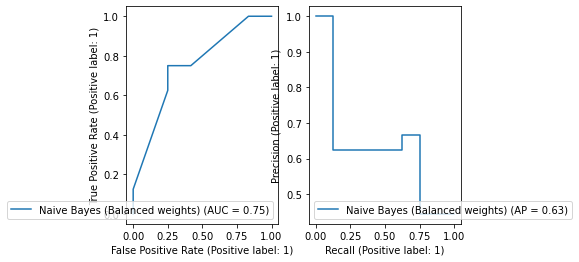

In [31]:
label_encoder = preprocessing.LabelEncoder()

bal_accs_w = []
auc_scores_w = []
for i in range(len(df_list)):
    one_assay = df_list[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1)
    scaler = StandardScaler().fit(one_assay.iloc[:,:4])
    
    X = scaler.transform(one_assay.iloc[:,:4])
    y = label_encoder.fit_transform(one_assay.iloc[:,4])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state = 42)
    
    class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
    class_weights = dict(zip(np.unique(y_train), class_weights))
    
    class_wt = []
    for j in y_train:
        if j == 0:
            class_wt.append(class_weights[0])
        elif j == 1:
            class_wt.append(class_weights[1])
    
    clf_balanced = BernoulliNB(alpha = 50).fit(X_train, y_train, sample_weight = class_wt)

    y_pred_balanced = clf_balanced.predict(X_test)
    y_pred_prob = clf_balanced.predict_proba(X_test)
    print(i)
    print(classification_report(y_test,y_pred_balanced))
    
    bal_acc = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc)
    
    auc = metrics.roc_auc_score(y_test, y_pred_prob[:, 1])
    auc_scores_w.append(auc)

    fig, (ax, ax1) = plt.subplots(1,2)
#     ax = plt.gca()

    RocCurveDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax,name="Naive Bayes (Balanced weights)")
    
#     ax1 = plt.gca()

    PrecisionRecallDisplay.from_estimator(clf_balanced, X_test, y_test,ax=ax1,name="Naive Bayes (Balanced weights)")

    plt.show()

In [32]:
print(np.mean(bal_accs_w))
print(np.mean(auc_scores_w))

0.7395833333333333
0.796875
